In [450]:
"""
 unsupervised_ML.ipynb

 Use unsupervised learning to cluster the time series data into different groups.
"""

'\n unsupervised_ML.ipynb\n\n Use unsupervised learning to cluster the time series data into different groups.\n'

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, isqrt, ceil
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from sklearn.metrics import silhouette_score

c:\Users\Anuvrat\OneDrive\Documents\siads\milestone2\venv_milestone2\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [9]:
../data/close_prices_adj_top_unsupervised.pkl

In [3]:
# Define common variables
data_folder = '../data/'
seed=42
data_start_date='2023-01-01'

In [4]:
# Load datasets
top500_data_nona = pd.read_pickle(data_folder + 'top500_data_nona.pkl')

In [ ]:
# Extract the adjusted close prices
close_prices_adj = top500_data_nona.xs('Adj Close', axis=1, level=0)
close_prices_adj.columns.name = None
close_prices_adj.index.name = None

In [5]:
# Pick top 20 stocks based on latest adjusted close price - Change the logic. The adjusted close price is not a good indicator of the top stocks.
top_stocks=list(close_prices_adj[close_prices_adj.index==close_prices_adj.index.max()].reset_index(drop=True, inplace=False).T.rename(columns={0:'Adj Close'})['Adj Close'].sort_values(ascending=False)[0:20].index)
#top_stocks

In [6]:
# Define top 20 stocks based on inputs from an external source (Investopedia)
top_stocks=['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B', 'META', 'UNH', 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 'PG', 'MA', 'AVGO', 'HD', 'CVX', 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']
existing_top_stocks = [col for col in top_stocks if col in close_prices_adj.columns] #4 stocks are not in the dataset - BRK.B, ABBV, META, TSLA

In [7]:
# Select the top 20 stocks since 1st Jan 2019
close_prices_adj_top=close_prices_adj[existing_top_stocks][close_prices_adj.index>=data_start_date]
# Save the dataset as a pickle file
close_prices_adj_top.to_pickle(data_folder + 'close_prices_adj_top_unsupervised.pkl')
#close_prices_adj_top.head()

In [425]:
# Define the TS clustering model
iterations=10
distance_metric='dtw' #{“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)
num_clusters=4
model = TimeSeriesKMeans(n_clusters=num_clusters, metric=distance_metric, max_iter=iterations, random_state=seed)

In [426]:
# Preprocess the data
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X = scaler.fit_transform(close_prices_adj_top.T.values)
X = close_prices_adj_top.T  # Not using the scaler to plot the values. Comment this out later on, if needed

In [427]:
# Calculate original mean and standard deviation of the time series data for each stock
original_means = dict(np.mean(close_prices_adj_top, axis=0))
original_stds = dict(np.std(close_prices_adj_top, axis=0))

In [428]:
# Fit the model and predict from the data
pred_cluster=model.fit_predict(X)

In [429]:
# Evaluation of the clusters
print(f"Inertia: {model.inertia_}")
print(f"Silhouette Score: {silhouette_score(X, pred_cluster)}") #X[:, :, 0]

Inertia: 133114.39019450458
Silhouette Score: 0.5884923567310694


DTW Scaled: Inertia: 11, Silhouette Score: 0.13 || 
DTW Non-scaled: Inertia: 227879, Silhouette Score: 0.56

SoftDTW Non-scaled: Inertia: 86959127000, Silhouette Score: 0.56

In [430]:
dict_predicted_clusters=dict(zip(close_prices_adj_top.columns, pred_cluster))

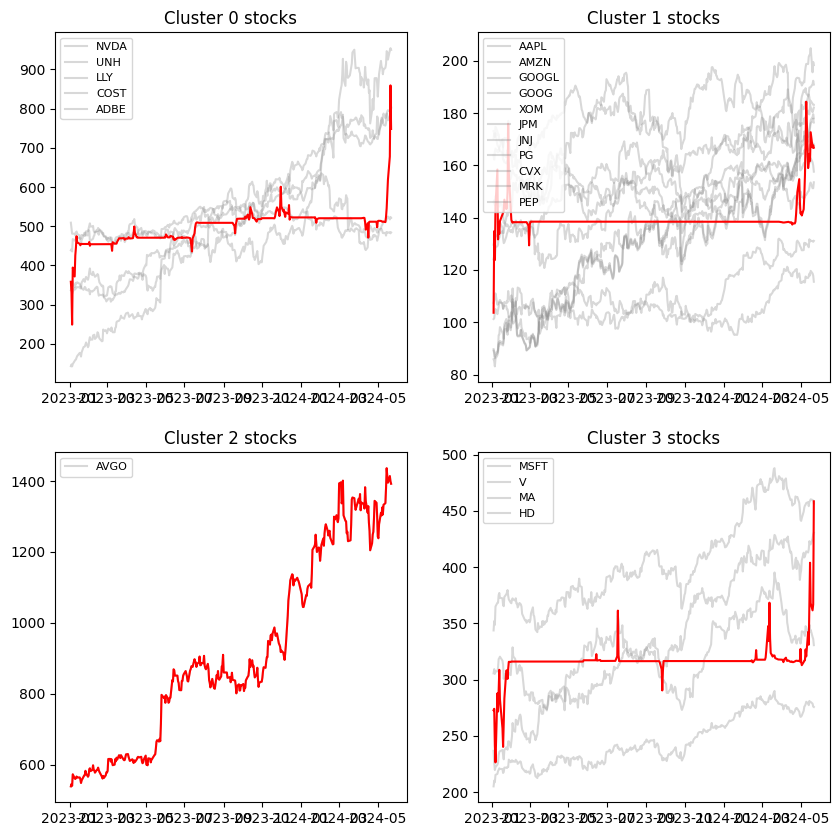

In [431]:
# Plot the clusters
int_sqrt = isqrt(num_clusters)
full_sqrt = sqrt(num_clusters)

if int_sqrt==full_sqrt: #Check if the number of clusters is a perfect square
    nrows=int_sqrt
    ncols=int_sqrt
else:
    nrows=int_sqrt+1
    ncols=ceil(num_clusters/(int_sqrt+1))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i in range(num_clusters):
    if nrows==1:
        ax=axs[i]
    else:
        ax=axs[i//ncols, i%ncols]
    
    stocks_in_cluster = [key for key in dict_predicted_clusters if dict_predicted_clusters[key] == i]
    ax.plot(close_prices_adj_top[stocks_in_cluster], color='gray', alpha=0.3)
    ax.plot(close_prices_adj_top[stocks_in_cluster].index, model.cluster_centers_[i].ravel(), 'r')

    ax.set_title(f'Cluster {i} stocks') #{stocks_in_cluster}
    ax.legend(stocks_in_cluster, loc='upper left', fontsize=8)
    #ax.set_xticks([])
    #ax.set_yticks([])


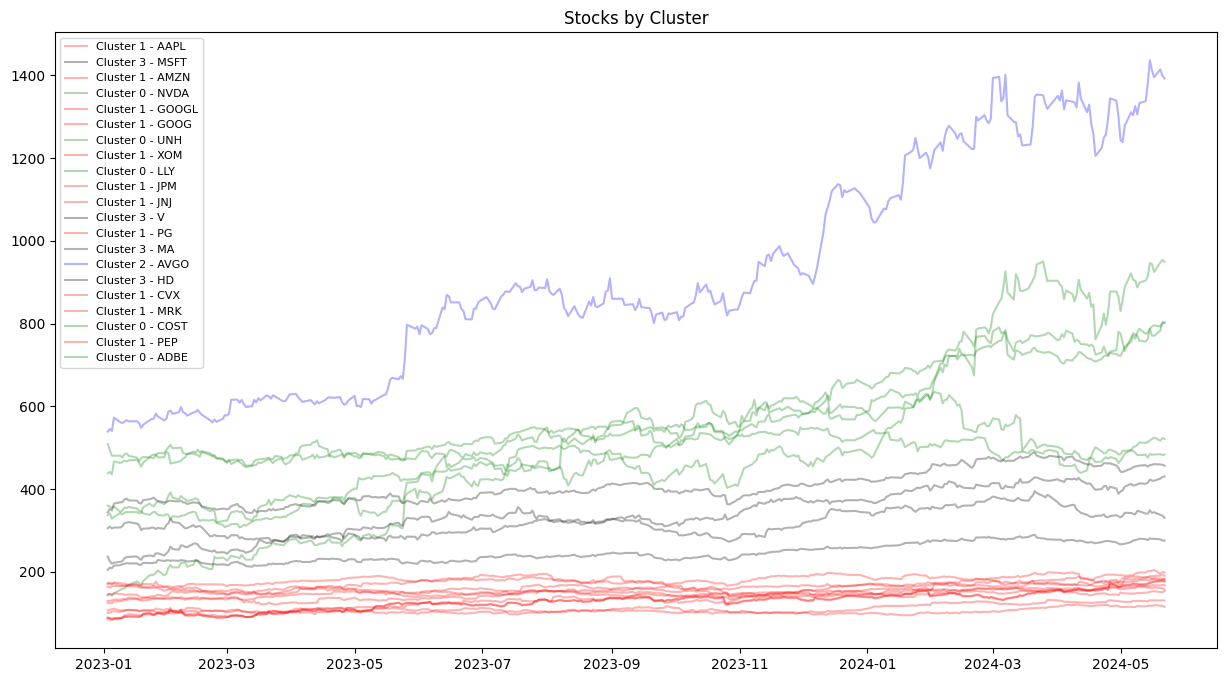

In [448]:
# Number of clusters
num_clusters = len(set(dict_predicted_clusters.values()))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

dict_color = {0: 'green', 1: 'red', 2: 'blue', 3: 'black'}

# Plot each stock with its cluster color and add a label for the legend
for key in dict_predicted_clusters:
    cluster = dict_predicted_clusters[key]
    ax.plot(close_prices_adj_top[key], color=dict_color[cluster], alpha=0.3, label=f'Cluster {cluster} - {key}')

# Using a dictionary to avoid duplicate labels in the legend and to track them
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', fontsize=8)

ax.set_title('Stocks by Cluster')
plt.show()


# Using a different approach - Kmeans on aggregated data

In [372]:
#Calculating annual mean returns and variances - There are typically 252 trading days in a year
returns = close_prices_adj_top.pct_change().mean() * 252
variance = close_prices_adj_top.pct_change().std() * sqrt(252)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]

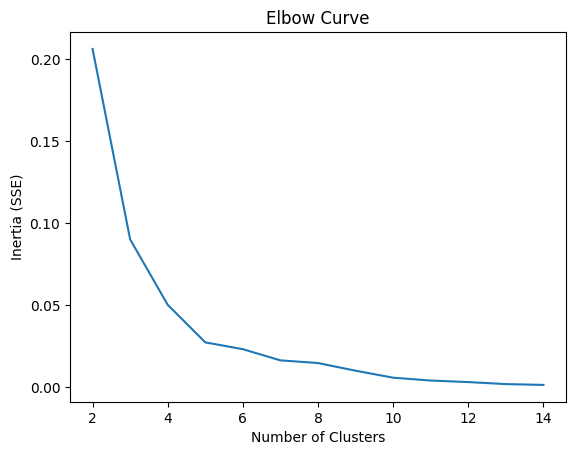

In [378]:
X =  ret_var.values #Converting ret_var into nummpy array
sse = []
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters
plt.plot(range(2,15), sse)
plt.title("Elbow Curve")
# Add x and y axis labels
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)") # Lower inertia is better
plt.show()

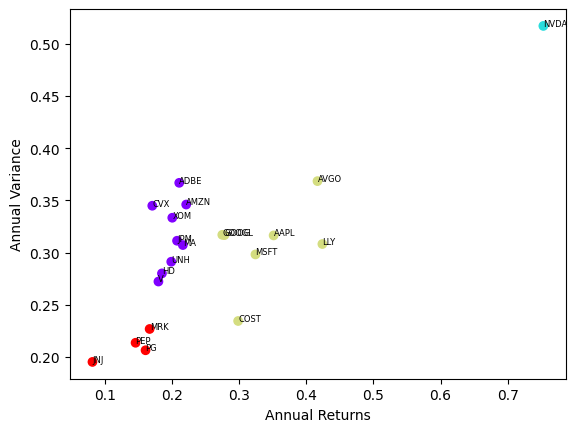

In [376]:
kmeans = KMeans(n_clusters = 4).fit(X)
centroids = kmeans.cluster_centers_
# Plot the data points with the cluster colors
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
# Add x and y axis labels
plt.xlabel("Annual Returns")
plt.ylabel("Annual Variance")
# Add labels to the points
for i in range(len(X)):
    plt.text(X[i][0], X[i][1], ret_var.index[i], size=6)
plt.show()

In [379]:
print(returns.idxmax())
ret_var.drop("NVDA", inplace =True)

NVDA


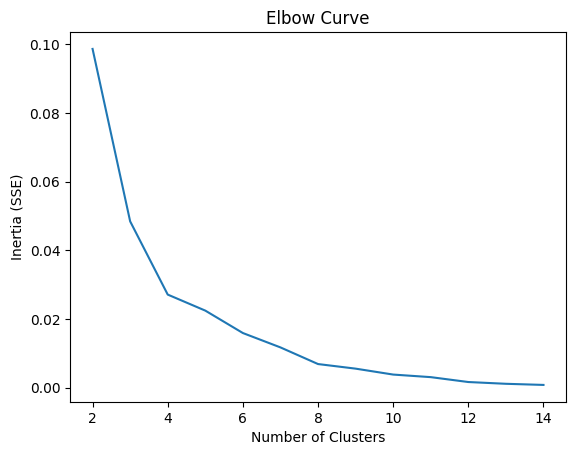

In [380]:
# Replotting elbow curve with out lier removed
X = ret_var.values
sse = []
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters
plt.plot(range(2,15), sse)
plt.title("Elbow Curve")
# Add x and y axis labels
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)") # Lower inertia is better
plt.show()

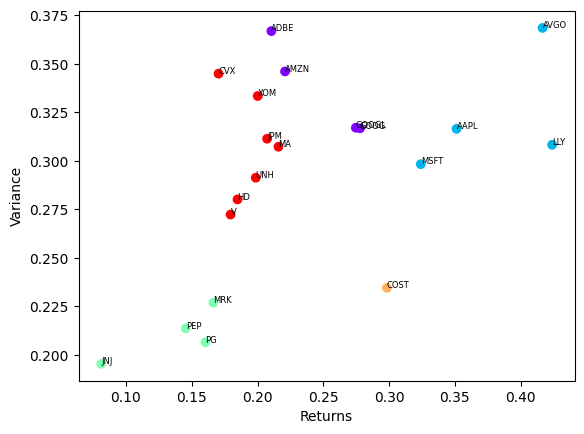

In [382]:
X = ret_var.values
kmeans =KMeans(n_clusters = 5).fit(X)
centroids = kmeans.cluster_centers_
# Plot the data points with the cluster colors
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
# Add x and y axis labels
plt.xlabel("Returns")
plt.ylabel("Variance")
for i in range(len(X)):
    plt.text(X[i][0], X[i][1], ret_var.index[i], size=6)
plt.show()